In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

import cv2
import tensorflow as tf
from tensorflow import keras
import os
from keras import applications

In [2]:
!unzip /content/MaskedDataset.zip

Archive:  /content/MaskedDataset.zip
   creating: MaskedDataset/
   creating: MaskedDataset/test/
   creating: MaskedDataset/test/Abdallah Shehata/
  inflating: MaskedDataset/test/Abdallah Shehata/IMG_3385.HEIC  
  inflating: MaskedDataset/test/Abdallah Shehata/IMG_5344.jpg  
  inflating: MaskedDataset/test/Abdallah Shehata/IMG_5754.HEIC  
   creating: MaskedDataset/test/Ahmed Roshdi/
  inflating: MaskedDataset/test/Ahmed Roshdi/WhatsApp Image 2021-12-22 at 6.34.03 PM (2).jpeg  
  inflating: MaskedDataset/test/Ahmed Roshdi/WhatsApp Image 2021-12-22 at 6.34.03 PM.jpeg  
  inflating: MaskedDataset/test/Ahmed Roshdi/WhatsApp Image 2021-12-22 at 6.34.04 PM.jpeg  
   creating: MaskedDataset/test/Joe/
  inflating: MaskedDataset/test/Joe/WhatsApp Image 2021-12-24 at 5.44.26 PM.jpeg  
  inflating: MaskedDataset/test/Joe/WhatsApp Image 2021-12-24 at 5.44.27 PM (1).jpeg  
  inflating: MaskedDataset/test/Joe/WhatsApp Image 2021-12-24 at 5.44.29 PM.jpeg  
   creating: MaskedDataset/test/Mostafa Mo

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
#img_gen = ImageDataGenerator(rescale=1./255) # assign a image generator

#training_set = img_gen.flow_from_directory(directory='../input/ants-bees/hymenoptera_data/train', target_size=(224,224), 
#                                           classes=['ants', 'bees'], batch_size=10)
#test_set = img_gen.flow_from_directory(directory= '../input/ants-bees/hymenoptera_data/val', target_size=(224,224), classes=['ants', 'bees'], 
#                                       batch_size=10, shuffle=False)

In [49]:
NUM_CLASSES = 7

CHANNELS = 3

IMAGE_RESIZE = 128
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 3


BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten , GlobalAveragePooling2D , Conv2D, MaxPooling2D, ZeroPadding2D 
#from tensorflow.keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization



In [51]:
#resnet = ResNet50(
 #   weights='imagenet',
  #  include_top=False,
#  input_shape=(224,224,3)
#)

img_rows, img_cols = 224, 224
model = vgg16.VGG16(weights = 'imagenet', include_top=False,
input_shape = (img_rows, img_cols, 3))



In [52]:
#Freeze the VGG16 layers
for layer in model.layers: 
  layer.trainable = False


In [53]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:
import tensorflow
#model = Sequential()
#model.add(resnet)
#model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
#model.add(tensorflow.keras.layers.Dropout(0.5))
#model.add(tensorflow.keras.layers.BatchNormalization())
#model.add(tensorflow.keras.layers.Dense(2, activation='softmax'))


def layer_adder(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model 


In [55]:
num_classes = 7
FC_Head = layer_adder(model, num_classes)
model = Model(inputs = model.input, outputs = FC_Head)


In [56]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [57]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = "../content/MaskedDataset/train"
validation_data_dir = "../content/MaskedDataset/test"

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20, width_shift_range =0.3, height_shift_range =0.3,  horizontal_flip=True, fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 1

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size ,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
         validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical') 


Found 49 images belonging to 7 classes.
Found 19 images belonging to 7 classes.


In [63]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("face_detector.h15", monitor = "val_loss", mode ="min", save_best_only = True, verbose=1)
#checkpoint = ModelCheckpoint("face_detector.h15", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,verbose=1,factor=0.2, min_lr=1e-7)
earlystop = EarlyStopping(monitor = "val_loss", min_delta = 0, patience =3, verbose=1, restore_best_weights = True)

callbacks = [checkpoint ,earlystop]

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
epochs = 10
batch_size = 2
history = model.fit_generator(train_generator, epochs = epochs, callbacks = callbacks, validation_data = validation_generator)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8571
Epoch 00001: val_loss improved from inf to 1.78931, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
49/49 [==============================] - 32s 627ms/step - loss: 0.3869 - accuracy: 0.8571 - val_loss: 1.7893 - val_accuracy: 0.4211
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9184
Epoch 00002: val_loss improved from 1.78931 to 0.67871, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
49/49 [==============================] - 30s 623ms/step - loss: 0.2653 - accuracy: 0.9184 - val_loss: 0.6787 - val_accuracy: 0.6316
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.9184
Epoch 00003: val_loss did not improve from 0.67871
49/49 [==============================] - 28s 564ms/step - loss: 0.3715 - accuracy: 0.9184 - val_loss: 0.711

In [ ]:
model.save('finalmodel.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
history.history

{'accuracy': [0.5319148898124695,
  0.7765957713127136,
  0.8500000238418579,
  0.800000011920929,
  0.8399999737739563,
  0.8936170339584351,
  0.9399999976158142,
  0.8799999952316284,
  0.8936170339584351,
  0.8999999761581421,
  0.9468085169792175,
  0.9200000166893005,
  0.9399999976158142,
  0.9399999976158142,
  0.914893627166748,
  0.9599999785423279,
  0.9700000286102295,
  0.9700000286102295,
  0.978723406791687,
  0.9800000190734863],
 'loss': [1.1437873840332031,
  0.6084012985229492,
  0.3877345323562622,
  0.4162746071815491,
  0.3575408160686493,
  0.31270211935043335,
  0.18080845475196838,
  0.2760348618030548,
  0.2297581136226654,
  0.22369569540023804,
  0.16458623111248016,
  0.19906730949878693,
  0.145508274435997,
  0.12392524629831314,
  0.1529962122440338,
  0.0943770483136177,
  0.08142649382352829,
  0.08179038017988205,
  0.07894442230463028,
  0.036513444036245346],
 'lr': [1e-04,
  1e-04,
  1e-04,
  1e-04,
  1e-04,
  1e-04,
  1e-04,
  1e-04,
  1e-04,
  1e

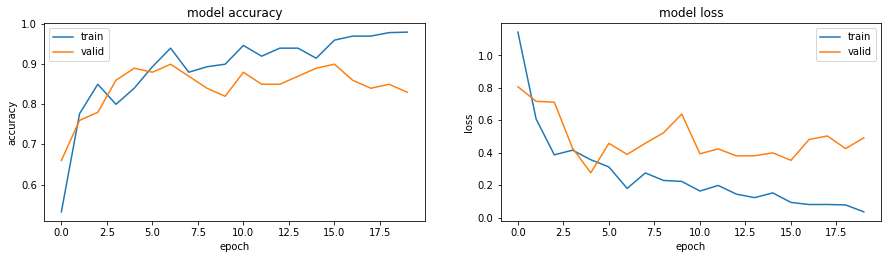

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()